# Chapter 4 - Classification

- [Load *Default* dataset](#Load-Default-dataset)
- [Figure 4.1: *Default* data set](#Figure-4.1:-Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
  - [Figure 4.2: Balance - Default, Estimated Probability](#Figure-4.2:-Balance---Default,-Estimated-Probability)
  - [Table 4.1: Balance - Default, Estimated Coefficients](#Table-4.1:-Balance---Default,-Estimated-Coefficients)
  - [Table 4.2: Student - Default, Estimated Coefficients](#Table-4.2:-Student---Default,-Estimated-Coefficients)
  - [Table 4.3: Balance, Income, Student - Default, Multiple Logistic Regression](#Table-4.3:-Balance,-Income,-Student---Default,-Multiple-Logistic-Regression)
  - [Figure 4.3: Confounding in the *Default* data](#Figure-4.3:-Confounding-in-the-Default-data)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
  - [Table 4.4: A Confusion Matrix (Decision Probability = 50%)](#Table-4.4:-A-Confusion-Matrix-(Decision-Probability-=-50%))
  - [Table 4.5: A Confusion Matrix (Decision Probability = 20%)](#Table-4.5:-A-Confusion-Matrix-(Decision-Probability-=-20%))
  - [Figure 4.7: Threshold - Error Rate](#Figure-4.7:-Threshold---Error-Rate)
  - [Figure 4.8: A ROC curve](#Figure-4.8:-A-ROC-curve)
- [4.6 Lab: Logistic Regression, LDA, QDA, and KNN](#4.6-Lab:-Logistic-Regression,-LDA,-QDA,-and-KNN)
  - [4.6.1 The Stock Market Data](#4.6.1-The-Stock-Market-Data)
  - [4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
  - [4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
  - [4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
  - [+ Naive Bayes Classifier](#+-Naive-Bayes-Classifier)
  - [4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from statsmodels.discrete.discrete_model import Logit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

%matplotlib inline
plt.style.use('seaborn-white')

warnings.filterwarnings('ignore')

---
### Load *Default* dataset

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')

df.head(3)

Unnamed: 0 default student      balance        income
0           1      No      No   729.526495  44361.625074
1           2      No     Yes   817.180407  12106.134700
2           3      No      No  1073.549164  31767.138947

In [3]:
# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default'] = df.default.factorize()[0]
df['student'] = df.student.factorize()[0]
df.head(3)

Unnamed: 0  default  student      balance        income
0           1        0        0   729.526495  44361.625074
1           2        0        1   817.180407  12106.134700
2           3        0        0  1073.549164  31767.138947

---
###  Figure 4.1: *Default* data set

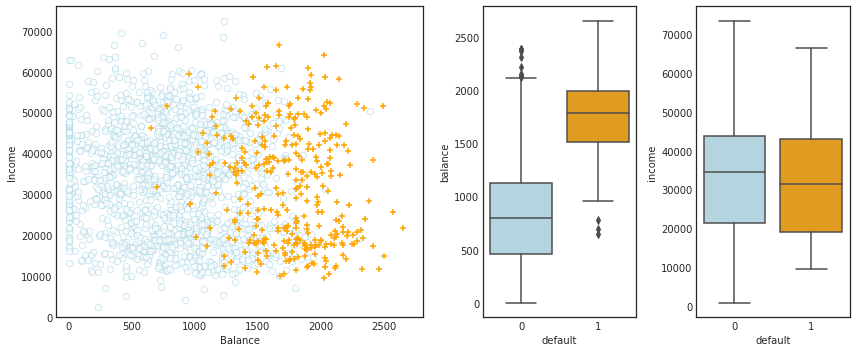

In [4]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default == 1]

ax1.scatter(df_no.balance, df_no.income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)
ax1.scatter(df_yes.balance, df_yes.income, s=40, c='orange', marker='+',
            linewidths=1)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

---
## 4.3 Logistic Regression
### Figure 4.2: Balance - Default, Estimated Probability

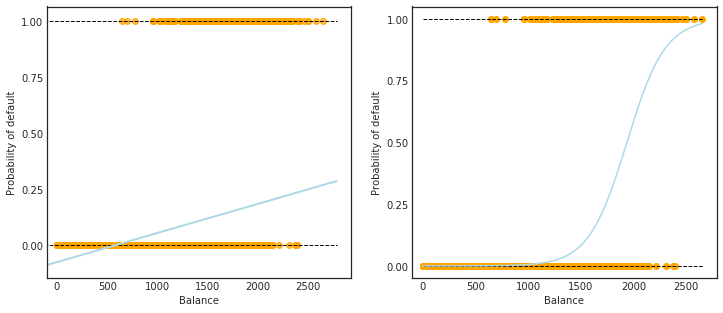

In [5]:
X_train = df.balance.values.reshape(-1,1)
y_train = df.default

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(df.balance, df.default, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y_train, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

---
### Table 4.1: Balance - Default, Estimated Coefficients

##### Using  scikit-learn

In [6]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book.
X_train = df.balance.values.reshape(-1,1)
y_train = df.default

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132784]


##### Using statsmodels

In [7]:
X_train = sm.add_constant(df.balance)
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const   -10.651331  0.361169 -29.491287  3.723665e-191 -11.359208 -9.943453
balance   0.005499  0.000220  24.952404  2.010855e-137   0.005067  0.005931

---
###  Table 4.2: Student - Default, Estimated Coefficients

In [8]:
X_train = sm.add_constant(df.student)
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


Coef.  Std.Err.          z     P>|z|    [0.025    0.975]
const   -3.504128  0.070713 -49.554094  0.000000 -3.642723 -3.365532
student  0.404887  0.115019   3.520177  0.000431  0.179454  0.630320

---
###  Table 4.3: Balance, Income, Student - Default, Multiple Logistic Regression

In [9]:
X_train = sm.add_constant(df[['balance', 'income', 'student']])
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const   -10.869045  0.492273 -22.079320  4.995499e-108 -11.833882 -9.904209
balance   0.005737  0.000232  24.736506  4.331521e-135   0.005282  0.006191
income    0.000003  0.000008   0.369808   7.115254e-01  -0.000013  0.000019
student  -0.646776  0.236257  -2.737595   6.189022e-03  -1.109831 -0.183721

---
### Figure 4.3: Confounding in the *Default* data

In [10]:
# balance and default vectors for students
X_student = df[df.student == 1].balance.values.reshape(df[df.student == 1].balance.size,1) 
y_student = df[df.student == 1].default

# balance and default vectors for non-students
X_not_student = df[df.student == 0].balance.values.reshape(df[df.student == 0].balance.size,1) 
y_not_student = df[df.student == 0].default

clf_student = skl_lm.LogisticRegression(solver='newton-cg')
clf_not_student = skl_lm.LogisticRegression(solver='newton-cg')

clf_student.fit(X_student, y_student)
clf_not_student.fit(X_not_student, y_not_student)

prob_student = clf_student.predict_proba(X_test)
prob_not_student = clf_not_student.predict_proba(X_test)

In [11]:
df.groupby(['student','default']).size().unstack('default')

default     0    1
student           
0        6850  206
1        2817  127

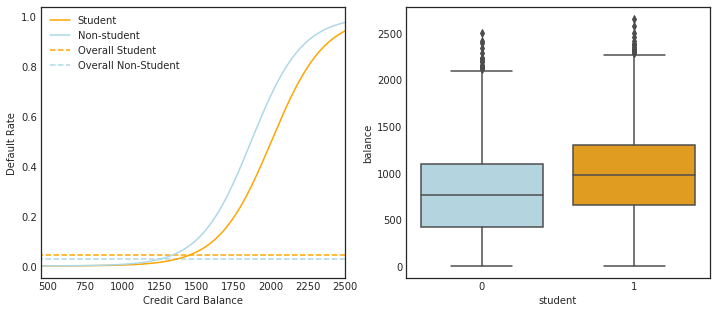

In [12]:
# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob_student)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob_not_student)[1], color='lightblue', label='Non-student')
ax1.hlines(df[df.default == 1][df.student == 1].shape[0]/df[df.student == 1].shape[0],
           colors='orange',
           label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(df[df.default == 1][df.student == 0].shape[0]/df[df.student == 0].shape[0],
           colors='lightblue',
           label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

---
## 4.4 Linear Discriminant Analysis
### Table 4.4: A Confusion Matrix (Decision Probability = 50%)

In [13]:
X = df[['balance', 'income', 'student']].as_matrix()
y_true = df.default.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y_true).predict(X)

df_ = pd.DataFrame({'True default status': y_true,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9645  254
Yes                         22   79

In [14]:
print(classification_report(y_true, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



---
### Table 4.5: A Confusion Matrix (Decision Probability = 20%)
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [15]:
decision_prob = 0.2
y_prob = lda.fit(X, y_true).predict_proba(X)

df_ = pd.DataFrame({'True default status': y_true,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9435  140
Yes                        232  193

---
### Figure 4.7: Threshold - Error Rate

In [16]:
thresholds = np.arange(0, 0.52, 0.01)
default_customer_error_rates = []
non_default_customer_error_rates = []
error_rates = []

for threshold in thresholds:
    y_pred = y_prob[:, 1] > threshold
    default_customer_error_rate = np.sum(np.logical_and(y_pred == 0, y_true == 1)) / np.sum(y_true == 1)
    non_default_customer_error_rate = np.sum(np.logical_and(y_pred == 1, y_true == 0)) / np.sum(y_true == 0)
    error_rate = np.sum(y_pred != y_true) / y_pred.size
    
    default_customer_error_rates.append(default_customer_error_rate)
    non_default_customer_error_rates.append(non_default_customer_error_rate)
    error_rates.append(error_rate)

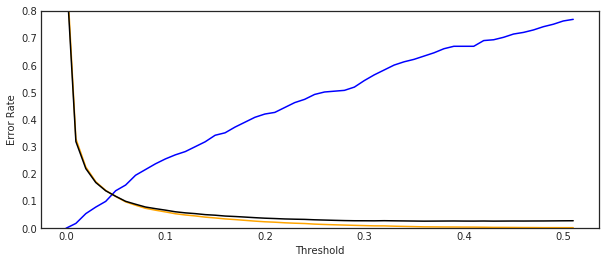

In [17]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.ylim(0, 0.8)
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.plot(thresholds, default_customer_error_rates, color='blue')
plt.plot(thresholds, non_default_customer_error_rates, color='orange')
plt.plot(thresholds, error_rates, color='black')

---
### Figure 4.8: A ROC curve

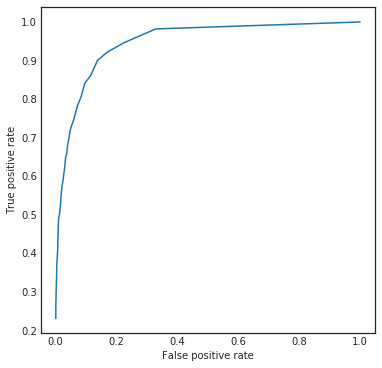

In [18]:
false_positive_rates = non_default_customer_error_rates
true_positive_rates = [1 - x for x in default_customer_error_rates]

plt.rcParams['figure.figsize'] = (6, 6)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(false_positive_rates, true_positive_rates)

---
## 4.6 Lab: Logistic Regression, LDA, QDA, and KNN

### 4.6.1 The Stock Market Data

In [19]:
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df.head(3)

Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
Year                                                                  
2001-01-01  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
2001-01-01  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2001-01-01  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down

---
### 4.6.3 Linear Discriminant Analysis

In [20]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X_train, y_train).predict(X_test)

In [21]:
lda.priors_

array([0.49198397, 0.50801603])

In [22]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [23]:
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [24]:
confusion_matrix(y_test, y_pred).T

array([[ 35,  35],
       [ 76, 106]])

In [25]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [26]:
y_prob = lda.predict_proba(X_test)

In [27]:
np.unique(y_prob[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182]))

In [28]:
np.unique(y_prob[:,1]>0.9, return_counts=True)

(array([False]), array([252]))

---
### 4.6.4 Quadratic Discriminant Analysis

In [29]:
qda = QuadraticDiscriminantAnalysis()
y_pred = qda.fit(X_train, y_train).predict(X_test)

In [30]:
qda.priors_

array([0.49198397, 0.50801603])

In [31]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [32]:
confusion_matrix(y_test, y_pred).T

array([[ 30,  20],
       [ 81, 121]])

In [33]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



---
### 4.6.5 K-Nearest Neighbors

In [34]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [35]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



### + Naive Bayes Classifier

In [36]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [37]:
y_pred = clf.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=clf.classes_,
                     columns=clf.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True       Down   Up
Predicted           
Down         29   20
Up           82  121
              precision    recall  f1-score   support

        Down       0.47      0.43      0.45       111
          Up       0.58      0.61      0.59       141

    accuracy                           0.53       252
   macro avg       0.52      0.52      0.52       252
weighted avg       0.53      0.53      0.53       252



---
### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [38]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Caravan.csv')
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

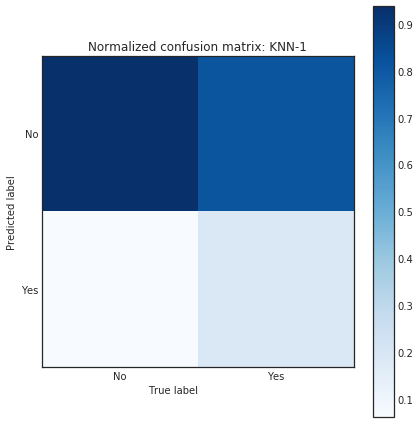

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


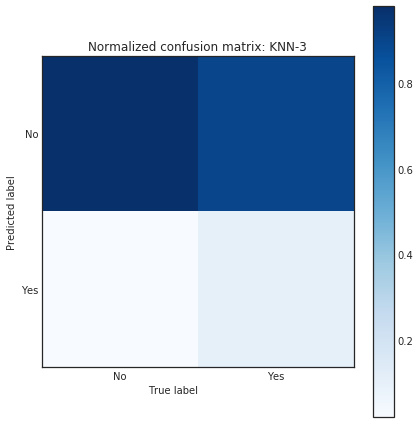

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


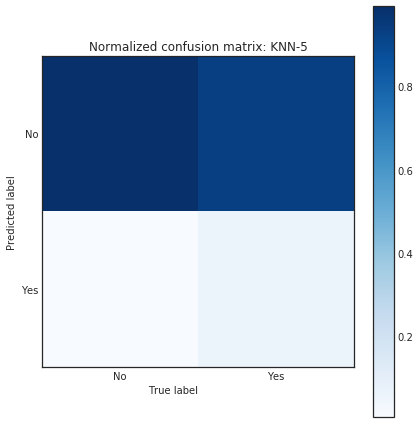

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [39]:
for i in [1,3,5]:
    pred, score, classes = KNN(i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

####  Logistic Regression

In [40]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
              precision    recall  f1-score   support

          No       0.94      0.99      0.97       941
         Yes       0.00      0.00      0.00        59

    accuracy                           0.94      1000
   macro avg       0.47      0.50      0.48      1000
weighted avg       0.89      0.94      0.91      1000



In [42]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    918   23
Yes    48   11
              precision    recall  f1-score   support

          No       0.95      0.98      0.96       941
         Yes       0.32      0.19      0.24        59

    accuracy                           0.93      1000
   macro avg       0.64      0.58      0.60      1000
weighted avg       0.91      0.93      0.92      1000

